# Описание проекта

**Цель исследования** - проанализировать рынок общественного питания Москвы и помочь инвесторам определить оптимальный формат заведения по типу, локации, ценовому сегменту и другим характеристикам.

**План работы**
1. Описание и предобработка данных
2.	Анализ структуры рынка (категории, районы, сетевость)
3.	Оценка ценового сегмента и среднего чека
4.	Изучение факторов успеха (рейтинг, вместимость, график)
5.	Детализация по формату “кофейня”
6.	Выводы и рекомендации для открытия заведения

**Описание данных**

Данные предоставлены сервисами Яндекс Карты и Яндекс Бизнес, лето 2022 года.
Каждая строка в датасете — это заведение общепита с информацией о:
- названии, типе, адресе, районе
- координатах, часах работы
- рейтинге, ценах, среднем чеке
- количестве посадочных мест
- принадлежности к сети

Всего в выборке — 8406 заведений.

# Предобработка данных

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('/datasets/moscow_places.csv')

In [3]:
# размер таблицы
print(data.shape[0])
print(data.shape[1])

# общая информация о типах данных и заполненности
print(data.info())

8406
14
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8406 non-null   object 
 1   category           8406 non-null   object 
 2   address            8406 non-null   object 
 3   district           8406 non-null   object 
 4   hours              7870 non-null   object 
 5   lat                8406 non-null   float64
 6   lng                8406 non-null   float64
 7   rating             8406 non-null   float64
 8   price              3315 non-null   object 
 9   avg_bill           3816 non-null   object 
 10  middle_avg_bill    3149 non-null   float64
 11  middle_coffee_cup  535 non-null    float64
 12  chain              8406 non-null   int64  
 13  seats              4795 non-null   float64
dtypes: float64(6), int64(1), object(7)
memory usage: 919.5+ KB
None


Выводы:
- Основная информация по каждому заведению: название, тип, адрес, координаты и рейтинг.
- Признаки цен (price, avg_bill, middle_avg_bill, middle_coffee_cup) и seats содержат пропуски — понадобится дополнительная обработка.
- Типы данных соответствуют содержимому: текстовые (object), числовые (float64, int64).

In [4]:
# Поиск дубликатов
print(data.duplicated().sum())

# Поиск неявных дубликатов по имени и адресу
duplicate_subset = data.duplicated(subset=['name', 'address'], keep=False)
duplicates = data[duplicate_subset]

print(duplicates.shape[0])

0
0


In [5]:
data['name'] = data['name'].str.strip().str.lower()
data['address'] = data['address'].str.strip().str.lower()
display(data.head(3))

,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats
0,wowфли,кафе,"москва, улица дыбенко, 7/1",Северный административный округ,"ежедневно, 10:00–22:00",55.878494,37.478860,5.0,NaN,NaN,NaN,NaN,0,NaN
1,четыре комнаты,ресторан,"москва, улица дыбенко, 36, корп. 1",Северный административный округ,"ежедневно, 10:00–22:00",55.875801,37.484479,4.5,выше среднего,Средний счёт:1500–1600 ₽,1550.0,NaN,0,4.0
2,хазри,кафе,"москва, клязьминская улица, 15",Северный административный округ,"пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...",55.889146,37.525901,4.6,средние,Средний счёт:от 1000 ₽,1000.0,NaN,0,45.0


Полных дубликатов в данных нет.
Неполных дубликатов нет.

In [6]:
tmp = data.copy()

# Поиск пропусков
def show_missing_stats(tmp0):
    missing_stats = pd.DataFrame({
        'Кол-во пропусков': tmp0.isnull().sum(),
        'Доля пропусков': tmp0.isnull().mean().round(2)
    })
    missing_stats = missing_stats[missing_stats['Кол-во пропусков'] > 0]
    return missing_stats.style.background_gradient(cmap='coolwarm') if not missing_stats.empty else "Пропусков в данных нет"
show_missing_stats(tmp)

,Кол-во пропусков,Доля пропусков
hours,536,0.060000
price,5091,0.610000
avg_bill,4590,0.550000
middle_avg_bill,5257,0.630000
middle_coffee_cup,7871,0.940000
seats,3611,0.430000


- Наиболее информативные столбцы — name, category, address, district, lat, lng, rating, chain — заполнены полностью, что позволяет проводить основную аналитику
- Ценовые признаки (avg_bill, middle_avg_bill, price, middle_coffee_cup) заполнены частично. Для анализа использовать только непустые строки.
- Признак seats можно дополнительно обработать — заполнить медианой внутри каждой категории заведений
- middle_coffee_cup лучше исключить из анализа из-за крайне малого количества значений.

In [7]:
data_filled = data.copy()

# Заполнение пропусков
categories = data_filled['category'].unique()
for cat in categories:
    median_value = data_filled.loc[data_filled['category'] == cat, 'seats'].median()
    data_filled.loc[
        (data_filled['category'] == cat) & (data_filled['seats'].isna()),
        'seats'
    ] = median_value
    
print("Осталось пропусков в 'seats':", data_filled['seats'].isna().sum())

Осталось пропусков в 'seats': 0


Заполнили пропуски в столбце seats медианными значениями по категориям 

In [8]:
def street_name(row):
    parts = row.split(',')
    if len(parts) > 1:
        return parts[1].strip()

data['street'] = data['address'].apply(street_name)

data.head(5)

,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats,street
0,wowфли,кафе,"москва, улица дыбенко, 7/1",Северный административный округ,"ежедневно, 10:00–22:00",55.878494,37.478860,5.0,NaN,NaN,NaN,NaN,0,NaN,улица дыбенко
1,четыре комнаты,ресторан,"москва, улица дыбенко, 36, корп. 1",Северный административный округ,"ежедневно, 10:00–22:00",55.875801,37.484479,4.5,выше среднего,Средний счёт:1500–1600 ₽,1550.0,NaN,0,4.0,улица дыбенко
2,хазри,кафе,"москва, клязьминская улица, 15",Северный административный округ,"пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...",55.889146,37.525901,4.6,средние,Средний счёт:от 1000 ₽,1000.0,NaN,0,45.0,клязьминская улица
3,dormouse coffee shop,кофейня,"москва, улица маршала федоренко, 12",Северный административный округ,"ежедневно, 09:00–22:00",55.881608,37.488860,5.0,NaN,Цена чашки капучино:155–185 ₽,NaN,170.0,0,NaN,улица маршала федоренко
4,иль марко,пиццерия,"москва, правобережная улица, 1б",Северный административный округ,"ежедневно, 10:00–22:00",55.881166,37.449357,5.0,средние,Средний счёт:400–600 ₽,500.0,NaN,1,148.0,правобережная улица


Добавили столбец с названием улицы

In [9]:
def is_24_7(hours):
    hours = str(hours).lower()
    return 'ежедневно' in hours and ('круглосуточно' in hours or '24/7' in hours)

data['is_24_7'] = data['hours'].apply(is_24_7)
# Проверим результат
print(data[['hours', 'is_24_7']].head(10))

                                               hours  is_24_7
0                             ежедневно, 10:00–22:00    False
1                             ежедневно, 10:00–22:00    False
2  пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...    False
3                             ежедневно, 09:00–22:00    False
4                             ежедневно, 10:00–22:00    False
5                             ежедневно, 10:00–23:00    False
6                  пн 15:00–04:00; вт-вс 15:00–05:00    False
7  пн-чт 10:00–22:00; пт,сб 10:00–23:00; вс 10:00...    False
8                             ежедневно, 10:00–22:00    False
9                             ежедневно, 12:00–00:00    False


Добавили столбец is_24_7 с обозначением то заведение работает ежедневно и круглосуточно (24/7)

# Промежуточные выводы ##

На первом этапе проекта был проведён обзор и предобработка данных о заведениях общественного питания Москвы (датасет на основе Яндекс.Карт и Яндекс.Бизнес, лето 2022 года).

Общая информация о данных:
- В выборке представлено 8406 заведений и 14 признаков, включая тип заведения, адрес, рейтинг, ценовую категорию, график работы и пр.
- Все ключевые признаки (название, категория, адрес, район, координаты, рейтинг, сетевое/несетевое) заполнены полностью, что позволяет использовать их в анализе без ограничений.
- Признаки, связанные с ценой (avg_bill, middle_avg_bill, price) и вместимостью (seats), содержат пропуски, что потребовало отдельной обработки.

Выполнена предобработка данных:
- Полные дубликаты в датасете не обнаружены.
- Пропуски:
middle_coffee_cup — исключён из анализа из-за очень малого покрытия (~6%).
price, avg_bill, middle_avg_bill — будут использоваться частично (только заполненные строки)
seats — заполнен медианой по каждой категории заведений
hours — оставлен без изменений (пропуски ~6%)

Добавлены новые столбцы:
- street — название улицы, выделенное из полного адреса.
- is_24_7 — отражает, работает ли заведение ежедневно и круглосуточно (24/7)


# Анализ данных

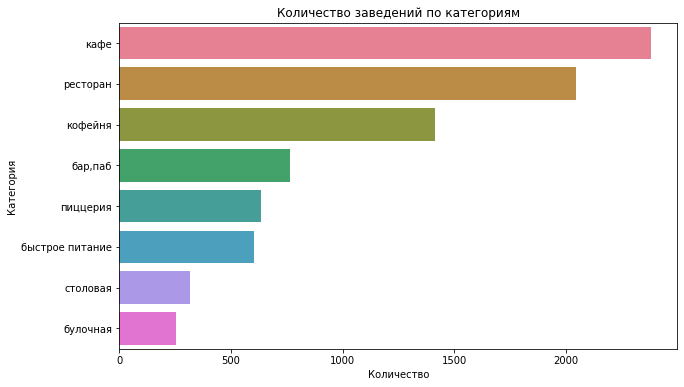

In [10]:
#Подсчёт количества заведений по категориям
category_count = data['category'].value_counts().sort_values(ascending=False)

import seaborn as sns 
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 6))
sns.barplot(
    x=category_count.values,
    y=category_count.index,
    palette="husl" )

plt.title('Количество заведений по категориям')
plt.xlabel('Количество')
plt.ylabel('Категория')
plt.show()

- Больше всего заведений в категории “кафе” — это самый популярный формат общественного питания в Москве.
- На втором месте — рестораны, что логично, учитывая разнообразие кухонь и уровней сервиса.
- Кофейни также широко представлены, уступая ресторанам, но опережая пиццерии и бары.
- Менее популярны: бары/пабы, пиццерии, заведения быстрого питания, столовые и булочные.


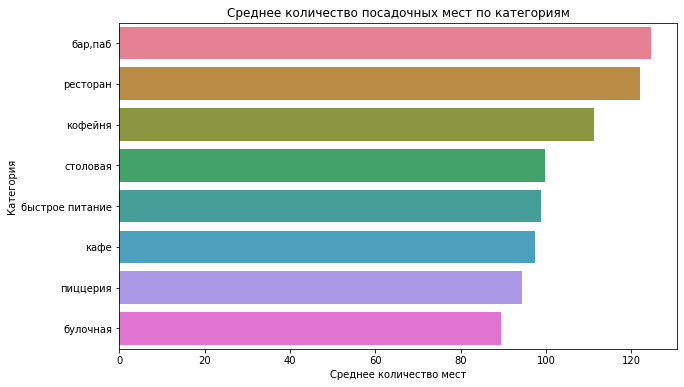

In [11]:
#Подсчет среднего колличества посадочных мест
category_seats = data.groupby('category')['seats'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=category_seats.values, y=category_seats.index, palette="husl")
plt.title('Среднее количество посадочных мест по категориям')
plt.xlabel('Среднее количество мест')
plt.ylabel('Категория')
plt.show()

- Больше всего посадочных мест в заведениях типа «бар, паб» — в среднем ~130 мест. Это логично, так как такие заведения часто ориентированы на большие компании.
- Рестораны и кофейни также показывают высокие средние значения — ~120 и ~110 мест соответственно.
- Столовые, заведения быстрого питания и кафе — располагают в среднем от 95 до 100 мест.
- Меньше всего посадочных мест в пиццериях и особенно булочных — в среднем менее 100 мест, что отражает их компактный формат.

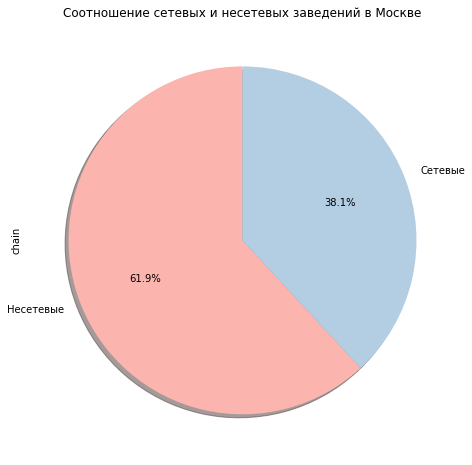

In [12]:
#Подсчет колличества сетевых и несетевых заведений 
chain_counts = data['chain'].value_counts()

labels = ['Несетевые', 'Сетевые']
colors = ['#fbb4ae', '#b3cde3']  

chain_counts.plot(
    kind='pie',
    figsize=(8, 8),
    startangle=90,
    shadow=True,
    labels=labels,
     autopct='%1.1f%%',
    colors=colors);

plt.title('Соотношение сетевых и несетевых заведений в Москве')
plt.show()

По данным из графика и анализа:
- Несетевых заведений больше — они составляют около 62% всех объектов.
- Сетевые заведения — около 38%.

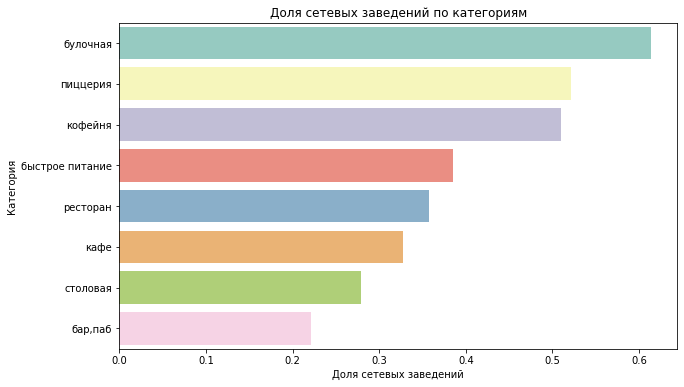

In [13]:
#Подсчет доли сетевых заведений по категорям 
category_place = data.groupby('category')['chain'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=category_place.values, y=category_place.index, palette="Set3")
plt.title('Доля сетевых заведений по категориям')
plt.xlabel('Доля сетевых заведений')
plt.ylabel('Категория')
plt.grid
plt.show()

Самая высокая доля сетевых точек наблюдается в следующих категориях:
- Пиццерии — почти все представляют собой сетевые бренды.
- Кофейни — также сильно представлены сетевыми операторами.
- Заведения быстрого питания — ожидаемо являются почти полностью сетевыми

Категории с наименьшей долей сетевых заведений:
- Бары и пабы — чаще всего являются независимыми и локальными.
- Рестораны — несмотря на большое количество, сетевых среди них существенно меньше.
- Булочные и столовые — преимущественно представлены одиночными заведениями.

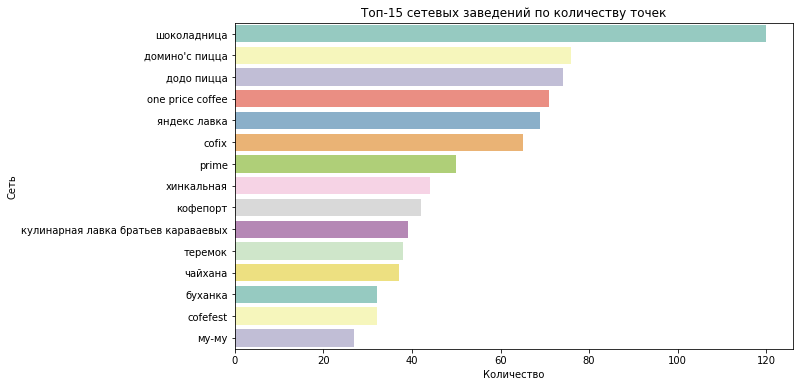

In [14]:
#Подсчет сетевых заведений по популярности
top_chains = data[data['chain'] == 1]['name'].value_counts().head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_chains.values, y=top_chains.index, palette="Set3")
plt.title('Топ-15 сетевых заведений по количеству точек')
plt.xlabel('Количество')
plt.ylabel('Сеть')
plt.grid
plt.show()

- Шоколадница — лидер среди сетей, с наибольшим числом заведений в Москве. Укреплённый бренд и формат «кофейня/кафе» сделали её самой масштабируемой сетью.
- За ней следуют Домино’с Пицца и Додо Пицца — успешные пиццерии, активно развивающиеся по франчайзингу.
- В топ также вошли One Price Coffee, Cofix, КОФЕПОРТ, CofeFest — кофейные сети с демократичным чеком.
- Prime, Яндекс Лавка, Караваевы — форматы здорового или быстрого питания.
- Теремок, Му-Му, Чайхана, Хинкальная, Буханка — популярные российские бренды, предлагающие блюда домашней, восточной и русской кухни.

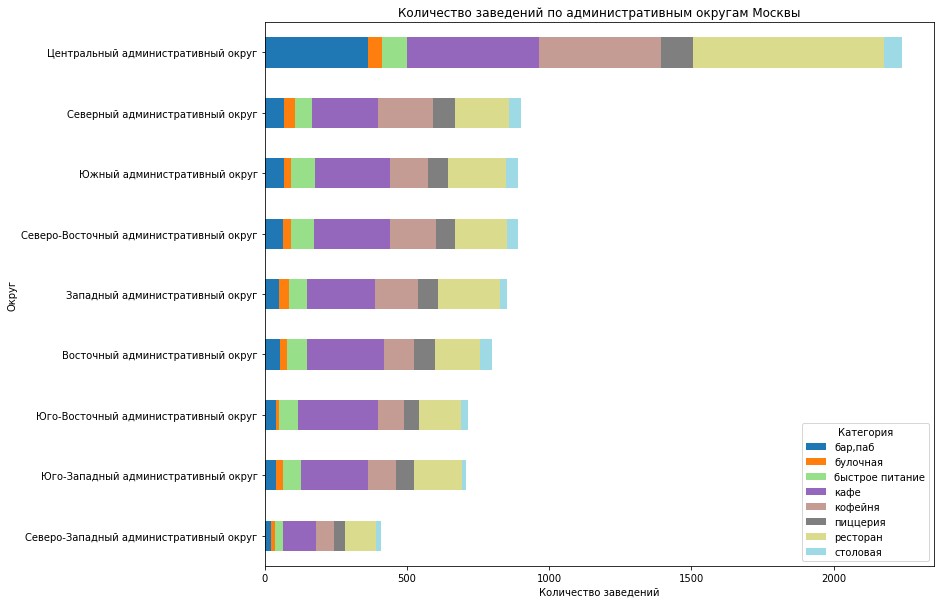

In [15]:
# Кол-во заведений по районам 
total_by_district = data.pivot_table(
    index='district', 
    columns='category', 
    values='name', 
    aggfunc='count')

# Сортировка по сумме заведений по району
total_by_district = total_by_district.loc[total_by_district.sum(axis=1).sort_values().index]

total_by_district.plot(
    kind='barh', 
    stacked=True, 
    figsize=(12, 10), 
    colormap='tab20');

plt.title('Количество заведений по административным округам Москвы')
plt.xlabel('Количество заведений')
plt.ylabel('Округ')
plt.legend(title='Категория')
plt.grid
plt.show()

- Центральный административный округ — абсолютный лидер: наибольшее количество заведений всех типов; особенно выделяются кофейни, пиццерии и рестораны.
- Северный, Южный, Юго-Западный и Юго-Восточный округа — средняя насыщенность, но структура схожа: преобладают кафе, кофейни, рестораны; кофейни занимают значительную долю почти в каждом районе.
- Булочные, столовые и бары встречаются реже — занимают небольшую часть диаграммы в большинстве округов.

Визуализация показывает, что все районы Москвы развиты в плане общественного питания, но:
- наиболее насыщенным и разнообразным остаётся ЦАО,
- форматы кофеен и кафе — ключевые в структуре заведений по всем районам.

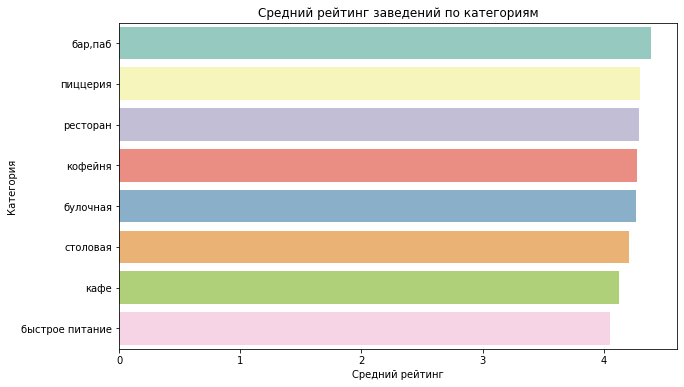

In [16]:
#Подсчет среднего рейтинга заведений по категориям
rating_cat = data.groupby('category')['rating'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=rating_cat.values, y=rating_cat.index, palette="Set3")
plt.title('Средний рейтинг заведений по категориям')
plt.xlabel('Средний рейтинг')
plt.ylabel('Категория')
plt.show()

Разброс рейтингов невелик — все значения находятся примерно в диапазоне от 4.0 до 4.4. Это говорит о том, что в целом пользователи хорошо оценивают заведения в Москве, независимо от их типа.
 
- Категории с самым высоким средним рейтингом: Бар/паб, пиццерия, ресторан. Эти типы заведений часто предлагают более индивидуальный подход, атмосферу и высокий уровень сервиса — это может способствовать получению более высоких оценок.

Ниже среднего: кафе, быстрое питание. Невысокий рейтинг может быть связан с массовостью, простым меню или отсутствием «вау»-эффекта.

Общий вывод:

Усреднённые рейтинги по категориям различаются незначительно, но:
- у форматов с более «персонализированным» подходом (ресторан, паб) — рейтинг выше;
- у массовых форматов (фастфуд, кафе) — немного ниже, но всё равно достаточно высокий.


In [17]:
from folium import Map
from folium import Choropleth
import pandas as pd

# Подсчет медианного рейтинга по районам
rating_by_district = data.groupby('district')['rating'].median().reset_index()
m = Map(location=[55.751244, 37.618423], zoom_start=10)

Choropleth(
    geo_data='/datasets/admin_level_geomap.geojson',
    data=rating_by_district,
    columns=['district', 'rating'],
    key_on='feature.name',
    legend_name='Медианный рейтинг заведений по районам'
). add_to(m)

m

- Центральный административный округ (ЦАО) выделяется как район с наивысшим медианным рейтингом заведений общественного питания. Это может быть связано с более высоким уровнем сервиса, туристическим трафиком и конкуренцией. Большинство заведений в ЦАО получают оценки ближе к 4.4.
- Районы второго круга Москвы (например, Северный, Восточный, Южный и др.) демонстрируют умеренные значения рейтингов — в пределах 4.25–4.35.
- Отдалённые округа на юге и юго-востоке города имеют наиболее низкие медианные значения — около 4.20–4.25. Это может говорить о более низком качестве обслуживания или меньшем внимании к атмосфере и сервису.

Общий вывод:
- Разброс между районами небольшой, но он существует.
- Центр города предлагает более качественные или высоко оценённые заведения.

In [ ]:
# Отображение всех заведений при помощт кластеров 
# Закомменировала одну строку, тк карта сильно лагает 

from folium import Marker
from folium.plugins import MarkerCluster

m = Map(location=[55.751244, 37.618423], zoom_start=11)

cluster = MarkerCluster().add_to(m)

def create_marker(row):
    Marker([row['lat'], row['lng']],
        popup=f"{row['name']} {row['rating']}"
    ).add_to(m)
    
data.apply(create_marker, axis=1)

m

- Центральные районы и прилегающие улицы — имеют максимальную концентрацию заведений: особенно плотными кластеры становятся в пределах Садового кольца.
- В спальных районах, промзонах и на окраинах — заведения размещены более разреженно, кластеры менее плотные или отсутствуют.


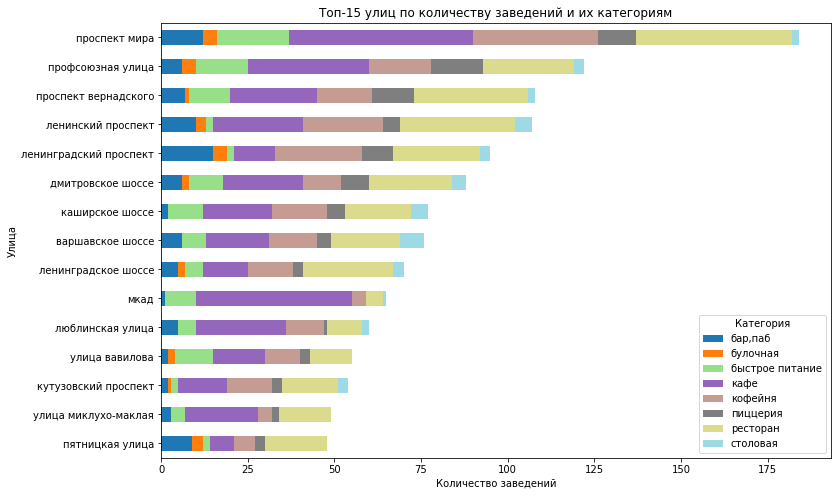

In [19]:
# Подсчет топ-15 улиц по кол-ву заведений и категориям 
top_street_names = data['street'].value_counts().head(15).index
top_data = data[data['street'].isin(top_street_names)]

top_streets = top_data.pivot_table(
    index='street',
    columns='category',
    values='name',
    aggfunc='count') 

# Сортировка 
top_streets = top_streets.loc[top_streets.sum(axis=1).sort_values().index]

top_streets.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 8),
    colormap='tab20')

plt.title('Топ-15 улиц по количеству заведений и их категориям')
plt.xlabel('Количество заведений')
plt.ylabel('Улица')
plt.legend(title='Категория')
plt.show()

- Проспект Мира — абсолютный лидер по количеству заведений. Особенно выделяются:кафе, рестораны и кофейни.
- Пополярными улицами так же являются - Профсоюзная улица и Проспект Вернадского. На этих улицах преобладают рестораны, кофейни и кафе, что говорит о высоком трафике и разнообразии форматов.
- Такие улицы, как МКАД, Каширское, Дмитровское и Варшавское шоссе — это скорее транспортные коридоры, где популярны форматы быстрого питания и небольшие кафе.
- Категории булочная, столовая и бар, паб встречаются редко и в небольшом объёме даже на популярных улицах.

- На большинстве улиц преобладают рестораны и кафе — это самые массовые и востребованные форматы.
- Кофейни уверенно занимают 3–4 место в структуре, особенно в центральных районах.
- Почти на каждой улице присутствует категориальное разнообразие — это может указывать на развитую конкурентную среду

In [20]:
# Подсчет медианного счета по районам
avg_district_bill = data.groupby('district')['middle_avg_bill'].median().reset_index()

m = Map(location=[55.751244, 37.618423], zoom_start=10)

Choropleth(
    geo_data='/datasets/admin_level_geomap.geojson',
    data=avg_district_bill,
    columns=['district', 'middle_avg_bill'],
    key_on='feature.name',
    legend_name='Медианный чек заведений по районам'
). add_to(m)

m

- Центральный административный округ (ЦАО) и прилегающие к нему районы (например, Западный, Юго-Западный) выделяются самым высоким медианным чеком — более 900–1000. Это объясняется наличием большого количества премиальных ресторанов, бизнес-центров, туристических и культурных объектов; Также в этих районах сосредоточены офисы, гостиницы и заведения высокого класса.
- Внешние округа, особенно на востоке и юго-востоке Москвы (например, ЮВАО, Зеленоградский, Южный, Новомосковский округ) показывают самые низкие медианные чеки — в пределах 400–600. Здесь преобладают недорогие форматы: столовые, кофейни, фастфуд; Целевая аудитория — местные жители, рабочие, транзитные пассажиры.
- Срединные по цене округа: Северный, Восточный, СВАО, ЗАО — удерживают баланс между недорогими кафе и более дорогими заведениями.

Общий вывод:

Цены в заведениях заметно коррелируют с удалённостью района от центра Москвы:
- В центре — выше аренда, выше конкуренция, выше чек.
- На периферии — больше “повседневных” форматов, ниже ценовой порог.

Это важно учитывать инвестору: в ЦАО можно делать ставку на премиальный сегмент, в отдалённых округах — на массовые и доступные форматы

# Общий вывод по исследованию рынка заведений общественного питания в Москве

**Структура рынка**
- Кафе — самая популярная категория заведений в Москве.
- За ней следуют рестораны, кофейни и пиццерии.
- Менее распространены бары/пабы, быстрое питание, столовые и булочные.

**Вместимость**
- Бары и пабы лидируют по числу посадочных мест (~130).
- Высокая вместимость также у ресторанов (~120) и кофейн (~110).
- Булочные и пиццерии — самые компактные (менее 100 мест).

**Сетевое vs. несетевое**
- Несетевых заведений больше — около 62% всех объектов.
- Пиццерии, кофейни и фастфуд — преимущественно сетевые.
- Бары, рестораны и булочные — в основном независимые.

**Популярные сети**
- Лидеры: Шоколадница, Домино’с Пицца, Додо Пицца, One Price Coffee, Cofix, Теремок, Му-Му, Prime и др.
- Большинство сетей относятся к форматам кофеен, быстрого питания и русской кухни.

**География и насыщенность**
- ЦАО — самый насыщенный и разнообразный округ: рестораны, кофейни, пиццерии.
- Средняя плотность в САО, ЮАО, ЮЗАО, ЮВАО.
- Булочные, бары и столовые представлены реже.

**Рейтинги**
- В целом оценки пользователей высокие — от 4.0 до 4.4.
- Бары, пиццерии и рестораны — получают самые высокие оценки.
- Кафе и фастфуд — чуть ниже по рейтингу, но всё ещё на хорошем уровне.

**Пространственное распределение**
- ЦАО и близлежащие улицы (Проспект Мира, Профсоюзная, Вернадского) — лидеры по числу заведений.
- Вдоль МКАД и шоссе — преобладает фастфуд и небольшие кафе.
- На улицах почти всегда встречается категориальное разнообразие — высокий уровень конкуренции.

**Ценовой анализ**
- ЦАО и западные округа — самые дорогие (чек от 900–1000 ₽).
- ЮВАО, Зеленоград, Новомосковский округ — самые дешёвые (чек 400–600 ₽).
- Чем ближе к центру — тем выше аренда, конкуренция и цены.
- На периферии — больше повседневных, доступных форматов.


**Заключение для инвестора**

- Форматы кафе, кофеен и ресторанов — наиболее массовые и востребованные.
- ЦАО — отличная локация для премиального сегмента, но высокая конкуренция и цены.
- Внешние округа — перспективны для масштабируемых, демократичных форматов.

# Детализация исследования: открытие кофейни

In [21]:
# Подсчет кол-ва кофеен в датасете 
coffee_count = data[data['category'] == 'кофейня'].shape[0]
print(f"Количество кофеен: {coffee_count}")

Количество кофеен: 1413


Центральный административный округ         428
Северный административный округ            193
Северо-Восточный административный округ    159
Западный административный округ            150
Южный административный округ               131
Восточный административный округ           105
Юго-Западный административный округ         96
Юго-Восточный административный округ        89
Северо-Западный административный округ      62
Name: district, dtype: int64

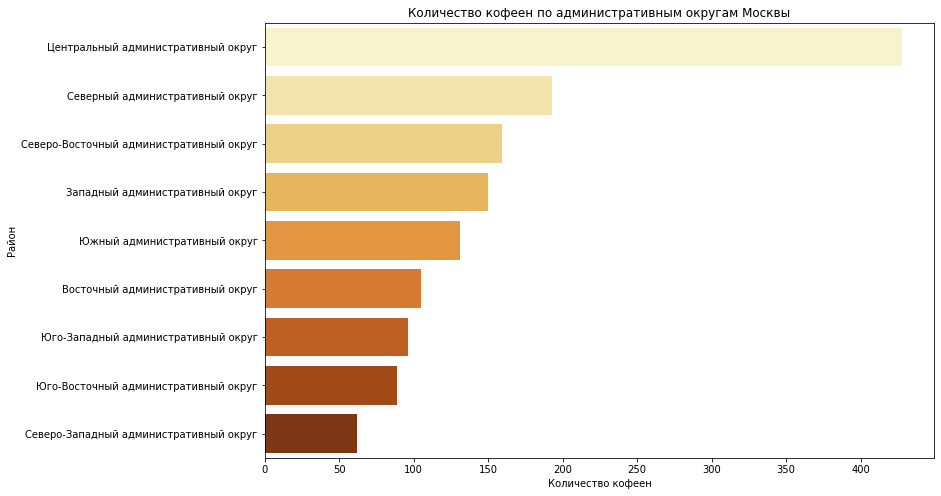

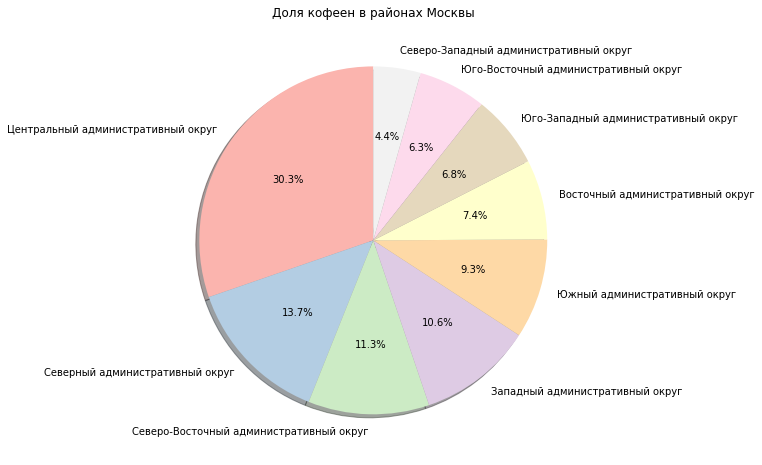

In [22]:
# Подсчет кол-ва кофеен по районам
coffee = data[data['category']== 'кофейня']
coffee_by_district = coffee['district'].value_counts().sort_values(ascending=False)
display(coffee_by_district)

plt.figure(figsize=(12, 8))
sns.barplot(
    x=coffee_by_district.values,
    y=coffee_by_district.index,
    palette='YlOrBr')

plt.title('Количество кофеен по административным округам Москвы')
plt.xlabel('Количество кофеен')
plt.ylabel('Район')
plt.show()

# Подсчет доли кофеен по районам
colors = ['#fbb4ae', '#b3cde3', '#ccebc5', '#decbe4', '#fed9a6',
          '#ffffcc', '#e5d8bd', '#fddaec', '#f2f2f2', '#b3e2cd']
coffee_by_district.plot(
    kind='pie',
    figsize=(8, 8),
    startangle=90,
    shadow=True,
    ylabel='',
    autopct='%1.1f%%',
    colors=colors)

plt.title('Доля кофеен в районах Москвы')
plt.grid
plt.show()

**Всего кофеен по Москве - 1413**

**Центральный административный округ** — абсолютный лидер по количеству кофеен:
- По pie chart: здесь сосредоточено более 30% всех кофеен Москвы, что в 2–3 раза больше, чем в любом другом округе.
- По barplot плотности: плотность кофеен на км² — в 5–10 раз выше, чем в других округах.
- высокая проходимость;
- туристический и деловой трафик;
- большое количество офисов, кафе на вынос и прогулочных зон;
- высокая конкуренция и концентрация заведений премиум и массового сегментов.

**Северные и северо-восточные округа:**
- По количеству занимают 2–3 места, ~11–14% от общего числа кофеен.
- По плотности — средний уровень: здесь присутствуют и жилые массивы, и деловые кластеры.
	•	💡 Кофейни активно развиваются вблизи метро, ТЦ и университетов.

**Западный, Южный и Юго-Западный округа:**
- В сумме занимают ~25% кофеен, с небольшим разбросом между собой.
- Западный округ ближе к бизнес-центрам и жилым комплексам, ЮЗАО — к университетам.
- Кофейни здесь чаще ориентированы на студентов и офисных сотрудников.

**Восточные и Юго-Восточные округа:**
- Умеренное количество кофеен — ~6–8%.
- Но плотность кофеен низкая — кофейни размещены точечн.
- Это районы с жилыми массивами и промзонами, где формат “кофе на вынос” ещё не так развит.

**Северо-Западный округ:**
- Самый низкий по количеству кофеен: менее 5% от общего числа.
- Плотность также низкая.
- Возможности для расширения: в этом округе — свободная ниша.

Количество круглосуточных кофеен: 59


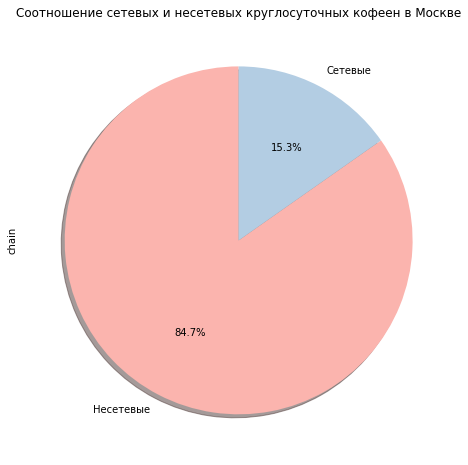

In [23]:
# Подсчет круглосуточных кофеен
coffee_24 = coffee[coffee['is_24_7'] == True]
print(f"Количество круглосуточных кофеен: {coffee_24.shape[0]}")

# Соотношение сетевых и несетевых круглосуточных кофеен
chain_coffee_24 = coffee_24['chain'].value_counts()

labels = ['Несетевые', 'Сетевые']
colors = ['#fbb4ae', '#b3cde3']  

chain_coffee_24.plot(
    kind='pie',
    figsize=(8, 8),
    startangle=90,
    shadow=True,
    labels=labels,
     autopct='%1.1f%%',
    colors=colors);

plt.title('Соотношение сетевых и несетевых круглосуточных кофеен в Москве')
plt.show()

**Количество круглосуточных кофеен: 59**

Среди круглосуточных кофеен Москвы:
- Несетевые заведения — явное большинство: 84.7%
- Сетевые составляют лишь 15.3%

Вывод:
- Независимые кофейни охотнее работают в формате 24/7 — возможно, это часть их конкурентной стратегии (например, близость к вокзалам, студенческим районам, клубам).
- Сетевые бренды, несмотря на широкий охват, реже предлагают круглосуточный режим — возможно, из-за корпоративных стандартов, ограничений франшизы или экономии ресурсов.

In [24]:
# Подсчет медианного рейтинга по районам 
rating_coffee_by_district = coffee.groupby('district')['rating'].median().reset_index()
display(rating_coffee_by_district)

m = Map(location=[55.751244, 37.618423], zoom_start=10)

Choropleth(
    geo_data='/datasets/admin_level_geomap.geojson',
    data=rating_coffee_by_district,
    columns=['district', 'rating'],
    key_on='feature.name',
    legend_name='Медианного рейтинга по районам'
). add_to(m)

m

,district,rating
0,Восточный административный округ,4.3
1,Западный административный округ,4.2
2,Северный административный округ,4.3
3,Северо-Восточный административный округ,4.3
4,Северо-Западный административный округ,4.3
5,Центральный административный округ,4.3
6,Юго-Восточный административный округ,4.3
7,Юго-Западный административный округ,4.3
8,Южный административный округ,4.3


**Общий уровень оценок:**
- Медианные рейтинги кофеен практически одинаковы во всех административных округах Москвы и находятся на высоком уровне — 4.2–4.3 балла. Это говорит о высоком и стабильном качестве кофеен, независимо от их расположения.

**Особенности по районам:**
- Западный административный округ немного отстаёт — медианный рейтинг кофеен составляет 4.2, в то время как в остальных округах — 4.3.
- Центральный, Северный, Восточный, Юго-Западный, Юго-Восточный и др. округа демонстрируют одинаково высокие оценки.

**Вывод:**
- Географическое положение не оказывает существенного влияния на качество кофеен (по оценке пользователей).
- Независимо от того, находятся ли кофейни в центре или на окраине — уровень сервиса и продукта остаётся стабильно хорошим.
- Это может говорить о высокой конкуренции и стандартах, особенно среди сетевых игроков.

,district,middle_coffee_cup
7,Юго-Западный административный округ,198.0
5,Центральный административный округ,190.0
1,Западный административный округ,189.0
4,Северо-Западный административный округ,165.0
3,Северо-Восточный административный округ,162.5
2,Северный административный округ,159.0
8,Южный административный округ,150.0
6,Юго-Восточный административный округ,147.5
0,Восточный административный округ,135.0


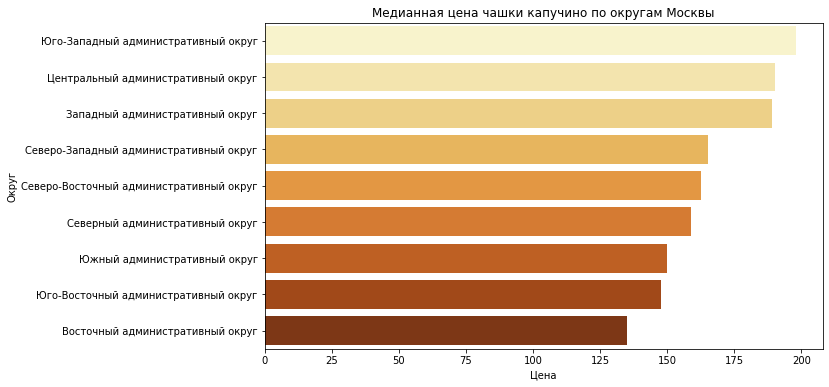

In [25]:
# Подсчет чашки капучино по районам 
middle_coffee_cup_by_district = coffee.groupby('district')['middle_coffee_cup'].median().reset_index()
display(middle_coffee_cup_by_district.sort_values(by='middle_coffee_cup', ascending=False))

sorted_df = middle_coffee_cup_by_district.sort_values(by='middle_coffee_cup', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='middle_coffee_cup',
    y='district',
    data=sorted_df,
    palette='YlOrBr'
)
plt.title('Медианная цена чашки капучино по округам Москвы')
plt.xlabel('Цена')
plt.ylabel('Округ')
plt.show()

**Вывод для открытия кофейни:**

- При выборе высокой ценовой стратегии (чек ~190–200 ₽) — имеет смысл открываться в ЦАО, ЮЗАО или ЗАО.
- При желании охватить массовый сегмент — лучше ориентироваться на цену 135–160 в восточных или южных округах.
- В среднем — капучино в Москве стоит около 160–165 ₽, и на эту сумму можно ориентироваться как на отправную точку.

<Figure size 864x432 with 0 Axes>

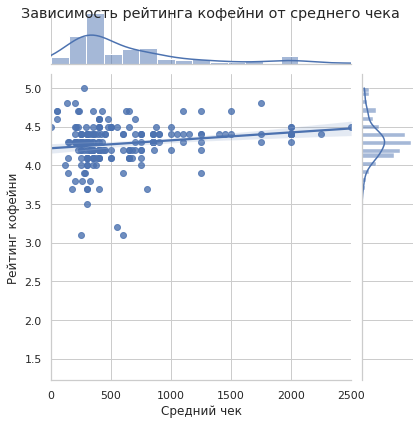

In [26]:
# Подсчет зависимости среднего чека от рейтинга 
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
g = sns.jointplot(
    x='middle_avg_bill', 
    y='rating', 
    data=coffee, 
    kind='reg')

g.ax_joint.set_xlabel('Средний чек')
g.ax_joint.set_ylabel('Рейтинг кофейни')
plt.suptitle('Зависимость рейтинга кофейни от среднего чека')
plt.show()

**Связь между рейтингом и средним чеком — не ярко выраженная.**
- На графике видно, что при увеличении среднего чека рейтинг немного растёт, но эта тенденция не ярко выражена.
- Большинство кофеен с рейтингом 4.0–4.5 имеют средний чек в диапазоне 200–700 рублей.

**Рассеяние точек широкое:**
- Есть кофейни с высоким рейтингом и при низком чеке (доступные и качественные).
- Есть и дорогие кофейни со средним рейтингом (высокая цена не гарантирует высокий рейтинг).

**Вывод для бизнеса:**
- Высокий рейтинг можно получить и при доступном среднем чеке, если заведение предлагает качественный продукт, сервис и атмосферу.
- При открытии новой кофейни ориентироваться на цену ~300–500 рублей — это комфортная зона, где сосредоточено большинство кофеен с хорошими оценками.

<Figure size 864x432 with 0 Axes>

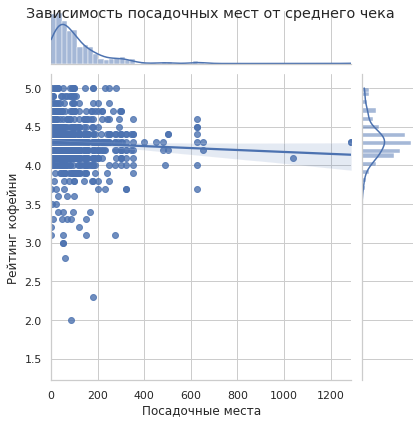

In [27]:
# Подсчет зависимости кол-ва посадочных мест от рейтинга 
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
g = sns.jointplot(
    x='seats', 
    y='rating', 
    data=coffee, 
    kind='reg')

g.ax_joint.set_xlabel('Посадочные места')
g.ax_joint.set_ylabel('Рейтинг кофейни')
plt.suptitle('Зависимость посадочных мест от среднего чека')
plt.show()

**Слабая зависимость**
- С увеличением количества посадочных мест рейтинг немного снижается.
- На графике видно, что кофейни с небольшим числом мест (до 100) чаще имеют высокие оценки (4.2–4.5).
- Большие залы (>300 мест) встречаются реже и чаще имеют рейтинг ниже 4.2.

**Возможные объяснения:**
- Маленькие кофейни часто более уютные, камерные, с персонализированным сервисом — это повышает лояльность клиентов и рейтинг.
- Большие залы — это чаще кафе и рестораны с кофейным меню, где кофе может быть не основным продуктом.

**Для открытия новой кофейни:**
- Оптимальный формат — 30–80 посадочных мест.
- Такой формат позволяет сохранить атмосферу, контролировать сервис и предложить высокий уровень качества.

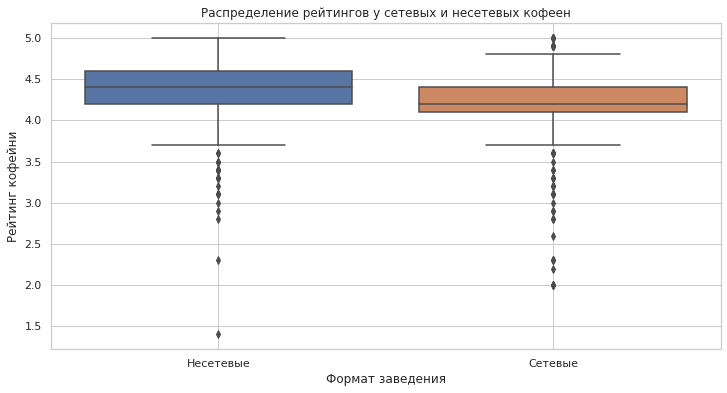

In [28]:
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

ax = sns.boxplot(
    x='chain', 
    y='rating', 
    data=coffee);

ax.set_xticklabels(['Несетевые', 'Сетевые'])
ax.set_xlabel('Формат заведения')
ax.set_ylabel('Рейтинг кофейни')
plt.title('Распределение рейтингов у сетевых и несетевых кофеен')
plt.grid(True)
plt.show()

- Медианный рейтинг у несетевых кофеен выше, чем у сетевых.
- Разброс у несетевых заведений больше — встречаются как очень высокие, так и крайне низкие оценки (вплоть до 1.4).
- Сетевые кофейни чаще получают оценки в диапазоне 4.1–4.3, то есть их качество более стандартизировано.
- У несетевых кофеен, несмотря на нестабильность, есть примеры заведений с наивысшими рейтингами (ближе к 5).

**Выводы**
- Сетевые кофейни выигрывают в стабильности — клиенты примерно знают, чего ожидать.
- Несетевые кофейни — потенциально более успешны с точки зрения рейтинга, если сделаны хорошо: атмосферные, уникальные, с авторским меню.

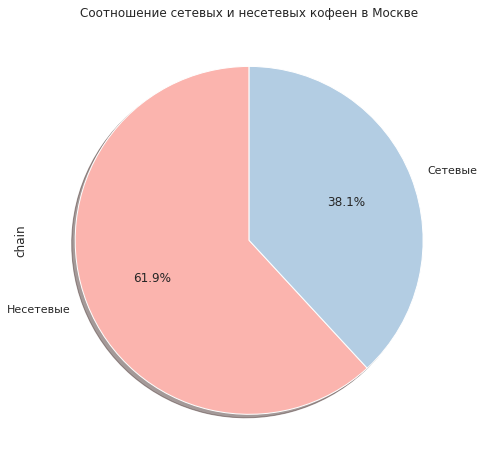

In [29]:
#Подсчет доли сетевых и несетевых кофеен 
chain_coffee = coffee['chain'].value_counts()

labels = ['Несетевые', 'Сетевые']
colors = ['#fbb4ae', '#b3cde3']  

chain_counts.plot(
    kind='pie',
    figsize=(8, 8),
    startangle=90,
    shadow=True,
    labels=labels,
     autopct='%1.1f%%',
    colors=colors);

plt.title('Соотношение сетевых и несетевых кофеен в Москве')
plt.show()

- Несетевые кофейни — 61.9% - преобладают на рынке, что указывает на высокий спрос на авторские, локальные и атмосферные форматы.
- Сетевые кофейни — 38.1% - чаще представлены в торговых центрах и у метро, обеспечивают стабильное качество и узнаваемость бренда.

- Москва — это рынок с развитой культурой индивидуальных кофеен, но стабильность и масштабируемость сетевых форматов сохраняют за ними значимую долю.

## Общий вывод

Исследование рынка кофеен в Москве показало:
 1. В Москве открыто около 1400 кофеен, и почти треть из них сосредоточена в Центральном административном округе. Это неудивительно: центр — главный трафик, бизнес, туризм.
 2. Кофейни — один из самых популярных форматов общепита в городе. По количеству они уступают лишь кафе и ресторанам.
 3.	Сетевых кофеен меньше (около 38%), но они чаще представлены в крупных торговых точках, а круглосуточными в основном оказываются несетевые заведения..
 4.	Рейтинги у всех кофеен довольно высокие — в среднем 4.2–4.3. Явных «провалов» по районам нет, но несетевые кофейни чуть-чуть выигрывают по оценкам.
 5.	Цены на капучино заметно отличаются: от 135₽ в восточных районах до почти 200₽ в центре и на юго-западе. Однако высокая цена не гарантирует лучший рейтинг — связь между чеком и оценкой есть, но слабая.
 6.	Прямая зависимость между ценой и рейтингом не прослеживается. Заведения с высоким рейтингом встречаются как среди дорогих, так и среди доступных по цене.
 7. Кофейни с малым количеством посадочных мест чаще получают более высокие оценки. Видимо, уют, камерность и персональное внимание действительно ценятся.

# Рекомендации для открытия кофейни

**Локация**
- Если есть возможность вложиться в премиальный сегмент — рассмотрите Центральный административный округ. Здесь высокая конкуренция, но и большой поток гостей, готовых платить за качество и атмосферу.
- При более скромном бюджете отлично подойдут Северо-Западный или Юго-Восточный округа — аренда ниже, кофейни там востребованы, а конкуренция умеренная.

**Формат**
- Идеально подойдёт небольшое, уютное пространство на 30–50 посадочных мест, где приятно провести время, но можно и взять кофе с собой.
- Такой формат проще обслуживать, он вызывает больше доверия у гостей и отлично вписывается в московский ритм.

**Цены**
- Ставьте цены в среднем сегменте — не слишком низкие (чтобы не работать себе в убыток) и не слишком высокие (чтобы не отпугнуть тех, кто просто хочет хороший кофе без пафоса).
- Капучино в районе 150–170 рублей — то, на что ориентируются большинство заведений в топовых районах.

Презентация: https://drive.google.com/file/d/1FyjeLrgay_G1wR2O6fYIl8k7Vw-0zQrC/view?usp=sharing